# Topic Modeling to Classification Modeling
Since our data is not grouped, we will begin by building a topic model. We will adjust that model as necessary until we feel satisfied with the topics discovered. We will subset our data to the topics we feel most comfortable with and use that resulting data set to build a classification model. 

Once that is complete we will report the accuracy of our classification model against a hold-out test set. 

You should find a data set that is organized into groups or that can be classified via topic modeling. The steps of your final project will vary depending on whether or not your data are grouped. If your data are grouped, then you will begin by building a classification model and reporting the accuracy of your model against a hold-out test set. Then you will ignore the groups and build a topic model such as NMF, LSA, or LDA to put the data into groups. You will then compare how well those topics agree with the a priori groups.  

## Import Libraries

In [27]:
# Import Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# from collections import Counter 
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import warnings  
warnings.filterwarnings('ignore')


## Helper Functions

In [3]:
# Add additional helper functions

# Stopwords
sw = stopwords.words("english")

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
# tw_punct = punctuation - {"#"} # Do this if there is punctuation you would like to ignore.

# Helper Functions - Cleaning data

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

def remove_punctuation(text, punct_set=punctuation) : 
    """This function removes punctuation from a string."""
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def remove_stop(tokens) :
    """This function removes stopwords from a list of tokens."""
    return([t for t in tokens if t.lower() not in sw])

def detokenize(list) : 
    """ Returning back a string from a list of tokens"""
    
    # modify this function to return string from tokens
    return(" ".join([str(e) for e in list]))
    
def prepare(text, pipeline) : 
    """ This fuction manages and executes other functions like a pipline. """
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data ETL and EDA

In [4]:
# Get Imported Data
arxiv_data = pd.read_pickle('G:\\My Drive\\ADS-509_Final_Team_Project\\arxiv_data_2023_02_13.pkl')
arxiv_data

,titles,abstracts,terms
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG]
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]"
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG]
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]"
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]"
...,...,...,...
64568,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]"
64569,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV]
64570,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]"
64571,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]"


In [5]:
# Data Review
print(f"There are {len(arxiv_data)} rows in the dataset.\n")

total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicated titles.\n")

dedup_arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()].reset_index()
print(f"There are {len(dedup_arxiv_data)} rows in the deduplicated dataset.\n")

# There are some terms with occurrence as low as 1.
occur = sum(dedup_arxiv_data["terms"].value_counts() == 1)
print(f"There are {occur} terms with an occurrence of 1.\n")

# How many unique terms?
unique_terms = dedup_arxiv_data["terms"].astype('str').nunique()
print(f"There are {unique_terms} unique terms.\n")

There are 64573 rows in the dataset.

There are 14237 duplicated titles.

There are 50336 rows in the deduplicated dataset.

There are 2907 terms with an occurrence of 1.

There are 3961 unique terms.



In [6]:
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5', 'category_6',
          'category_7', 'category_8', 'category_9',
          'category_10', 'category_11']

# Melt the categories to individual columns regardless of name or order.
df = dedup_arxiv_data.terms.apply(pd.Series)

# Name the columns for Clarity.
df.columns = columns

def add_dummies(df):
    uniqueValues = []
    for columnName in df:
        categories = df[columnName].unique().tolist()
        categories = [x for x in categories if x is not None]
        uniqueValues.extend(categories)
        uniqueValues = list(set(uniqueValues))

    print("Number of Categories:",len(uniqueValues))

    result_df = pd.concat([df,pd.DataFrame(columns = list(uniqueValues))])
    result_df.fillna(0, inplace = True)
    return result_df


cat = add_dummies(df)
cat



Number of Categories: 1382


,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,I.4.5,I.2.6; H.2.4,H.2.8; H.3.3,I.3,"68T09, 68T20, 68T01",I.2; I.5; I.2.4; I.2.6; I.5.1,"68T07, 65C35, 35K57, 49Q22",68-04,"65D15, 65D18, 65N06, 65N50, 65Z05, 68T20",cs.AR
0,cs.LG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,stat.ML,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cs.LG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cs.LG,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,cs.CV,cs.GR,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50332,cs.CV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50333,cs.CV,cs.GR,I.4; I.4.6;I.4.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50334,cs.CV,cs.MM,I.4.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Mark each of the categories with 1 if they exist.

# columns1 = ['category_1']

for col in columns:
    row = 0
    for row, category in enumerate(cat[col]):
        # print(category)
        if category != 0:
            cat.loc[row, category] = 1

# # Create New Dataframe with dummies appended.
description_category_new = pd.concat([dedup_arxiv_data['titles'],dedup_arxiv_data['abstracts'], 
dedup_arxiv_data['terms'], cat.iloc[:,11:]],
                                    axis=1)

# Drop the test Column
# description_category_new = description_category_new.drop(columns=['test'])

description_category_new.head()

,titles,abstracts,terms,I.2.1; I.2.6; I.5.4,physics.med-ph,I.2.8; I.2.6; G.3,I.2.6; I.4.10; I.3.3; I.5.4; I.5.1; I.3.7; I.3.8; I.2.10,93E03,I.4.7; I.5.4,I.2.10; I.4; I.5,...,I.4.5,I.2.6; H.2.4,H.2.8; H.3.3,I.3,"68T09, 68T20, 68T01",I.2; I.5; I.2.4; I.2.6; I.5.1,"68T07, 65C35, 35K57, 49Q22",68-04,"65D15, 65D18, 65N06, 65N50, 65Z05, 68T20",cs.AR
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
cat.isnull().values.any()

False

In [9]:
cat.isnull().sum()

category_1                                  0
category_2                                  0
category_3                                  0
category_4                                  0
category_5                                  0
                                           ..
I.2; I.5; I.2.4; I.2.6; I.5.1               0
68T07, 65C35, 35K57, 49Q22                  0
68-04                                       0
65D15, 65D18, 65N06, 65N50, 65Z05, 68T20    0
cs.AR                                       0
Length: 1393, dtype: int64

In [10]:
# Let's get the columns with the highest counts
bar_plot = pd.DataFrame()
bar_plot['cat'] = description_category_new.columns[3:]
bar_plot['count'] = description_category_new.iloc[:,3:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

,cat,count
0,cs.LG,28902
1,cs.CV,27981
2,stat.ML,11087
3,cs.AI,10249
4,cs.RO,2037


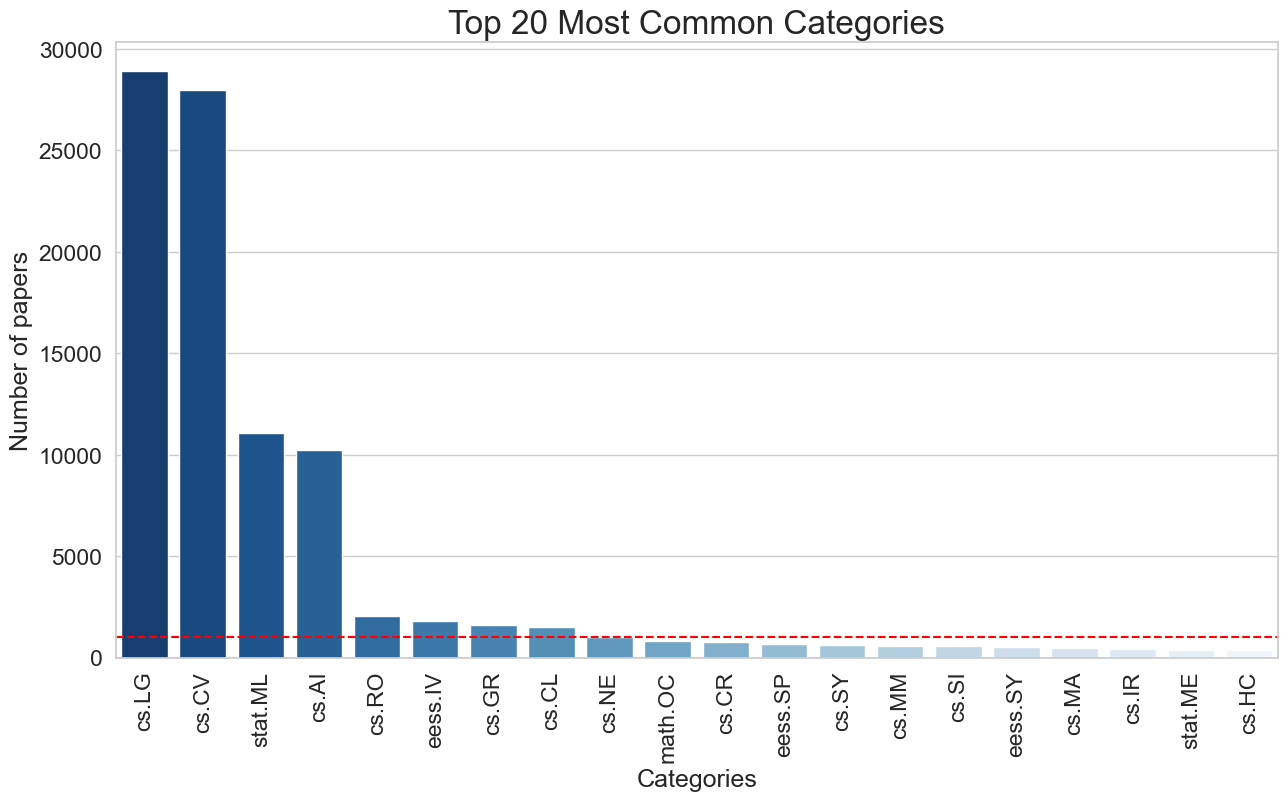

In [11]:
# Plot the Top N Most Common Categories.

top_n = 20
threshold = 1000

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot.head(top_n)))
rank = bar_plot['count'].head(top_n).argsort().argsort()  

sns.barplot(data = bar_plot.head(top_n), x='cat', y = 'count', palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title(f"Top {top_n} Most Common Categories", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('Categories', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

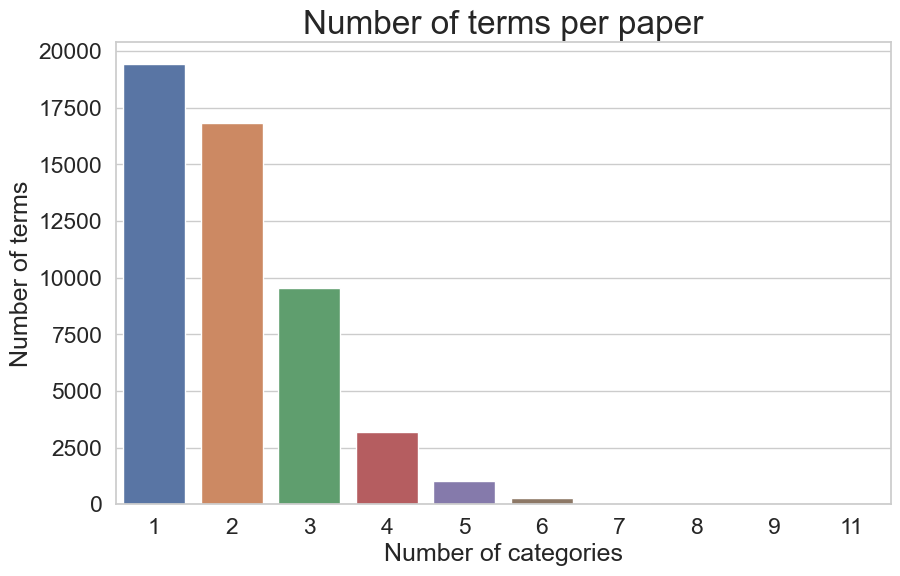

In [12]:
rowSums = description_category_new.iloc[:,3:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot( x = multiLabel_counts.index, y = multiLabel_counts.values)
plt.title("Number of terms per paper", fontsize=24)
plt.ylabel('Number of terms', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

In [13]:
# Consolidate Categories Based ON 1000 Term Threashold. Put everything else in Other bucket.

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>1000]
categories = main_categories['cat'].values
categories = np.append(categories,'Others')
not_category = []
description_category_new['Others'] = 0

description_category_new_consolidated = description_category_new.copy()

for i in description_category_new_consolidated.columns[3:]:
    if i not in categories:
        description_category_new_consolidated['Others'][description_category_new_consolidated[i] == 1] = 1
        not_category.append(i)

description_category_new_consolidated.drop(not_category, axis=1, inplace=True)


In [14]:
description_category_new_consolidated

,titles,abstracts,terms,eess.IV,cs.RO,cs.GR,stat.ML,cs.LG,cs.NE,cs.CV,cs.AI,cs.CL,Others
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG],0,0,0,0,1,0,0,0,0,0
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]",0,0,0,1,1,0,0,0,0,0
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG],0,0,0,0,1,0,0,0,0,0
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]",0,0,0,0,1,0,0,1,0,0
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",0,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]",0,0,1,0,0,0,1,0,0,0
50332,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV],0,0,0,0,0,0,1,0,0,0
50333,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",0,0,1,0,0,0,1,0,0,1
50334,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]",0,0,0,0,0,0,1,0,0,1


In [15]:
description_category_new_consolidated.describe().T

,count,mean,std,min,25%,50%,75%,max
eess.IV,50336.0,0.035382,0.184746,0.0,0.0,0.0,0.0,1.0
cs.RO,50336.0,0.040468,0.197056,0.0,0.0,0.0,0.0,1.0
cs.GR,50336.0,0.032084,0.176226,0.0,0.0,0.0,0.0,1.0
stat.ML,50336.0,0.220260,0.414426,0.0,0.0,0.0,0.0,1.0
cs.LG,50336.0,0.574182,0.494471,0.0,0.0,1.0,1.0,1.0
cs.NE,50336.0,0.020562,0.141913,0.0,0.0,0.0,0.0,1.0
cs.CV,50336.0,0.555884,0.496872,0.0,0.0,1.0,1.0,1.0
cs.AI,50336.0,0.203612,0.402687,0.0,0.0,0.0,0.0,1.0
cs.CL,50336.0,0.029641,0.169596,0.0,0.0,0.0,0.0,1.0
Others,50336.0,0.212353,0.408977,0.0,0.0,0.0,0.0,1.0


## Normalize and Clean Text


In [16]:
# Clean and Tokenize Data
df = description_category_new_consolidated.copy()

df["titles_abstracts"] = df["titles"] + df["abstracts"]


my_pipeline = [normalize, remove_punctuation, tokenize, remove_stop, detokenize]
df["summaries"] = df["titles_abstracts"].apply(prepare, pipeline=my_pipeline)

cols = ['terms','titles', 'abstracts', 'summaries',  
'cs.LG','cs.CV','stat.ML','cs.AI','cs.RO','eess.IV','cs.GR', 
 'cs.CL','cs.NE','Others']
df = df[cols]
df

,terms,titles,abstracts,summaries,cs.LG,cs.CV,stat.ML,cs.AI,cs.RO,eess.IV,cs.GR,cs.CL,cs.NE,Others
0,[cs.LG],Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",reinforcement learning multiple sensors via jo...,1,0,0,0,0,0,0,0,0,0
1,"[stat.ML, cs.LG]",Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,interventional causal representation learningc...,1,0,1,0,0,0,0,0,0,0
2,[cs.LG],Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,selfsupervised node representation learning vi...,1,0,0,0,0,0,0,0,0,0
3,"[cs.LG, cs.AI]",Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,outofdistribution representation learning time...,1,0,0,1,0,0,0,0,0,0
4,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,trading information latents hierarchical varia...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,"[cs.CV, cs.GR]",Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,plot 94 ambiance xwindowplot collection routin...,0,1,0,0,0,0,1,0,0,0
50332,[cs.CV],Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,automatic face recognition system based local ...,0,1,0,0,0,0,0,0,0,0
50333,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,convexity analysis snake models based hamilton...,0,1,0,0,0,0,1,0,0,1
50334,"[cs.CV, cs.MM, I.4.6]",Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,semiautomatic vectorization linear networks ra...,0,1,0,0,0,0,0,0,0,1


In [17]:
y = df.columns[4:]
y

Index(['cs.LG', 'cs.CV', 'stat.ML', 'cs.AI', 'cs.RO', 'eess.IV', 'cs.GR',
       'cs.CL', 'cs.NE', 'Others'],
      dtype='object')

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df.columns[4:])
y

array([[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]])

In [19]:
multilabel.classes_

array(['.', 'A', 'C', 'E', 'G', 'I', 'L', 'M', 'N', 'O', 'R', 'V', 'a',
       'c', 'e', 'h', 'r', 's', 't'], dtype=object)

In [20]:
df

,terms,titles,abstracts,summaries,cs.LG,cs.CV,stat.ML,cs.AI,cs.RO,eess.IV,cs.GR,cs.CL,cs.NE,Others
0,[cs.LG],Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",reinforcement learning multiple sensors via jo...,1,0,0,0,0,0,0,0,0,0
1,"[stat.ML, cs.LG]",Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,interventional causal representation learningc...,1,0,1,0,0,0,0,0,0,0
2,[cs.LG],Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,selfsupervised node representation learning vi...,1,0,0,0,0,0,0,0,0,0
3,"[cs.LG, cs.AI]",Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,outofdistribution representation learning time...,1,0,0,1,0,0,0,0,0,0
4,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,trading information latents hierarchical varia...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,"[cs.CV, cs.GR]",Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,plot 94 ambiance xwindowplot collection routin...,0,1,0,0,0,0,1,0,0,0
50332,[cs.CV],Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,automatic face recognition system based local ...,0,1,0,0,0,0,0,0,0,0
50333,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,convexity analysis snake models based hamilton...,0,1,0,0,0,0,1,0,0,1
50334,"[cs.CV, cs.MM, I.4.6]",Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,semiautomatic vectorization linear networks ra...,0,1,0,0,0,0,0,0,0,1


## Test Train Split

In [22]:
df.columns[4:]

Index(['cs.LG', 'cs.CV', 'stat.ML', 'cs.AI', 'cs.RO', 'eess.IV', 'cs.GR',
       'cs.CL', 'cs.NE', 'Others'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['summaries'], 
                                                    df[df.columns[4:]], 
                                                    test_size=0.3, 
                                                    random_state=43, 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## Classification Modeling

In [36]:
# Logistic Regression

LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for category in df.columns[4:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    conf_mat = confusion_matrix(
        y_test[category], prediction
        )
    print(conf_mat)
    print("\n")
    print("-"*40)

print('Test averaged AUC ROC is {}'.format(accuracy/len(df.columns[4:])))

**Processing cs.LG titles...**
AUC ROC score is 0.8641801493911652
[[5618  862]
 [1195 7426]]


----------------------------------------
**Processing cs.CV titles...**
AUC ROC score is 0.9410568098526846
[[6293  348]
 [ 554 7906]]


----------------------------------------
**Processing stat.ML titles...**
AUC ROC score is 0.7079844778699906
[[10816   948]
 [ 1680  1657]]


----------------------------------------
**Processing cs.AI titles...**
AUC ROC score is 0.5957771482700119
[[11377   621]
 [ 2348   755]]


----------------------------------------
**Processing cs.RO titles...**
AUC ROC score is 0.5368053608615541
[[14475    33]
 [  548    45]]


----------------------------------------
**Processing eess.IV titles...**
AUC ROC score is 0.5
[[14528     0]
 [  573     0]]


----------------------------------------
**Processing cs.GR titles...**
AUC ROC score is 0.5730128954560639
[[14570    49]
 [  410    72]]


----------------------------------------
**Processing cs.CL titles...**
A

In [37]:
# Multinomial Naive Bayes

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])
accuracy = 0
for category in df.columns[4:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    conf_mat = confusion_matrix(
        y_test[category], prediction
        )
    print(conf_mat)
    print("\n")
    print("-"*40)


print('Test averaged AUC ROC is {}'.format(accuracy/len(df.columns[4:])))

**Processing cs.LG titles...**
AUC ROC is 0.7985542588368053
[[4318 2162]
 [ 597 8024]]


----------------------------------------
**Processing cs.CV titles...**
AUC ROC is 0.8845962362898578
[[5255 1386]
 [ 187 8273]]


----------------------------------------
**Processing stat.ML titles...**
AUC ROC is 0.5
[[11764     0]
 [ 3337     0]]


----------------------------------------
**Processing cs.AI titles...**
AUC ROC is 0.5
[[11998     0]
 [ 3103     0]]


----------------------------------------
**Processing cs.RO titles...**
AUC ROC is 0.5
[[14508     0]
 [  593     0]]


----------------------------------------
**Processing eess.IV titles...**
AUC ROC is 0.5
[[14528     0]
 [  573     0]]


----------------------------------------
**Processing cs.GR titles...**
AUC ROC is 0.5
[[14619     0]
 [  482     0]]


----------------------------------------
**Processing cs.CL titles...**
AUC ROC is 0.5
[[14657     0]
 [  444     0]]


----------------------------------------
**Processing c

## Topic Modeling